# Reconhecimento de Padrões (TIP8311) - Trabalho 2


**Professor:** Guilherme de Alencar Barreto  

<img src="https://loop.frontiersin.org/images/profile/243428/203" alt="Foto do Professor" width="150"/>


**Aluno:** Luis Felipe Carneiro de Souza    **Matrícula:** 593034

**Objetivos**:

(1) Estimar a matriz de covariância de um conjunto de dados usando diferentes algoritmos, comparando de modo sistemático e científico o tempo de execução dos algoritmos de estimação.

(2) Avaliar a priori  a   invertibilidade   da   matriz   de   covariância   estimada.   

(3) Inverter   e   regularizar   matrizes   de covariância.

In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

In [71]:
path_sensor_4 = "wall+following+robot+navigation+data\sensor_readings_4.data"

path_sensor_24 = "wall+following+robot+navigation+data\sensor_readings_24.data"

Método 1

In [85]:
def cov_1(X):
    X = X.T
    p, N = X.shape
    soma = np.zeros((p, p))
    m = X.mean(axis=1).reshape(-1,1) # Vetor coluna
    for i in range(N):
        aux = X[:, i].reshape(-1, 1) - m
        soma += aux @ aux.T
    C = soma / N
    return C

Método 2

In [86]:
def cov_2(X):
    X = X.T
    p, N = X.shape
    m = X.mean(axis=1).reshape(-1,1) # Vetor coluna
    aux = X - m
    return (aux @ aux.T) / N

Método 3

In [87]:
def cov_3(X):
    X = X.T
    p, N = X.shape
    R = np.zeros((p, p))
    m = X.mean(axis=1).reshape(-1,1)
    for i in range(N):
        R += X[:, i].reshape(-1, 1) @ X[:, i].reshape(-1, 1).T

    C = (R / N) - (m @ m.T)
    return C

Método 4

In [88]:
def cov_4(X):
    X = X.T
    p, N = X.shape
    m = X.mean(axis=1).reshape(-1,1)
    R = (X @ X.T) / N
    C = R - (m @ m.T)
    return C

Método de referência para o calculo da matriz de covariância

In [89]:
def cov_ref(X):
    X = X.T
    return np.cov(X, bias=True)

## Q1.

Estimar a matriz de covariância GLOBAL (i.e. sem considerar os rótulos das classes) para o referido conjunto de dados usando os Métodos 1 a 4 descritos nos slides. Comparar como o resultado produzido pelo comando COV nativo Octave/Matlab ou de outra de programação de sua preferência. Para a comparação, calcular a norma da matriz de diferenças $E = C_{my} - C_{ref}$ em que $C_{my}$ é matriz de covariância estimada pelos métodos implementados $C_{ref}$ é a matriz de covariância de referência estimada pela função nativa da lingaugem de programação escolhida.

**Atenção!** Em geral, as funções nativas de diferentes linguagens de programação dividem por $(N-1)$ na estimação da matriz de covariância. Usem alguma *flag* para permitir a divisão por $N$

In [90]:
data_4 = np.genfromtxt(fname=path_sensor_4,
                       delimiter=",",
                       dtype=str,
                       encoding="utf-8")
data_24 = np.genfromtxt(fname=path_sensor_24,
                         delimiter=",",
                         dtype=str,
                         encoding="utf-8")

X_4 = data_4[:, :-1].astype(float)
y_4 = data_4[:, -1].reshape(-1,  1)

X_24 = data_24[:, :-1].astype(float)
y_24 = data_24[:, -1].reshape(-1, 1)

Para dados do sensor 4

In [92]:
C_ref_4 = cov_ref(X_4)
C1_4, C2_4, C3_4, C4_4 = cov_1(X_4), cov_2(X_4), cov_3(X_4), cov_4(X_4)

In [93]:
E1_4 = C1_4 - C_ref_4
E2_4 = C2_4 - C_ref_4
E3_4 = C3_4 - C_ref_4
E4_4 = C4_4 - C_ref_4


print(f"Norma E (cov_1): {np.linalg.norm(E1_4):.4e}")
print(f"Norma E (cov_2): {np.linalg.norm(E2_4):.4e}")
print(f"Norma E (cov_3): {np.linalg.norm(E3_4):.4e}")
print(f"Norma E (cov_4): {np.linalg.norm(E4_4):.4e}")


Norma E (cov_1): 3.8262e-15
Norma E (cov_2): 0.0000e+00
Norma E (cov_3): 3.8896e-14
Norma E (cov_4): 4.5067e-14


Para dado sendor 24

In [94]:
C_ref_24 = cov_ref(X_24)
C1_24, C2_24, C3_24, C4_24 = cov_1(X_24), cov_2(X_24), cov_3(X_24), cov_4(X_24)

In [95]:
E1_24 = C1_24 - C_ref_24
E2_24 = C2_24 - C_ref_24
E3_24 = C3_24 - C_ref_24
E4_24 = C4_24 - C_ref_24


print(f"Norma E (cov_1): {np.linalg.norm(E1_24):.4e}")
print(f"Norma E (cov_2): {np.linalg.norm(E2_24):.4e}")
print(f"Norma E (cov_3): {np.linalg.norm(E3_24):.4e}")
print(f"Norma E (cov_4): {np.linalg.norm(E4_24):.4e}")


Norma E (cov_1): 1.2295e-13
Norma E (cov_2): 5.5511e-17
Norma E (cov_3): 3.7817e-13
Norma E (cov_4): 2.8301e-13


## Questão 02

Comparar (de modo cientficamente correto!) os métodos implementados no Item 1 com o comando COV nativo do Octave/Matlab ou de outra linguagem de programação que melhor lhe convier em termos de tempo médio de execução. No Matlab/Octave usar os comandos tic/toc. Para isso, execute cada método por 100 rodadas, guardando o tempo de execução de cada método em cada rodada. Ao final das 100 rodadas, compare os gráficos do histograma e do violin plot do tempo de execução de cada método. Compare-os também numericamente em termos de tempo de execução médio e desvio-padrão. Comente os resultados obtidos.

Para dados do sensor 4

In [96]:
def calc_tempos(X):
    times = {'cov_1': [],
            'cov_2': [],
            'cov_3': [],
            'cov_4': []}

    for _ in tqdm(range(100)):
        t0 = time.time(); cov_1(X_4); times['cov_1'].append(time.time() - t0)
        t0 = time.time(); cov_2(X_4); times['cov_2'].append(time.time() - t0)
        t0 = time.time(); cov_3(X_4); times['cov_3'].append(time.time() - t0)
        t0 = time.time(); cov_4(X_4); times['cov_4'].append(time.time() - t0)

    for metodo, tempos in times.items():
        print(f"{metodo}: Média = {np.mean(tempos):.6f} s | Desvio-Padrão = {np.std(tempos):.6f} s")

    return times

In [97]:
def plot_violin_hist(times):
    fig, axes = plt.subplots(2,2, figsize=(8, 5))

    axes = axes.flatten()  # transformar em lista para iterar

    for i, (c, valores) in enumerate(times.items()):
        axes[i].violinplot(valores, showmeans=True, showmedians=True)
        axes[i].set_title(f"Método = {c}")
        axes[i].set_ylabel("Tempo de cálculo (s)")
        axes[i].grid(True, linestyle="--", alpha=0.6)

    plt.suptitle("Distribuição dos tempos de cálculo da matriz de covariância", fontsize=14)
    plt.tight_layout()
    plt.show()


In [98]:
times_4 = calc_tempos(X_4)

100%|██████████| 100/100 [00:01<00:00, 66.02it/s]

cov_1: Média = 0.007548 s | Desvio-Padrão = 0.000517 s
cov_2: Média = 0.000193 s | Desvio-Padrão = 0.000408 s
cov_3: Média = 0.007261 s | Desvio-Padrão = 0.000475 s
cov_4: Média = 0.000050 s | Desvio-Padrão = 0.000217 s


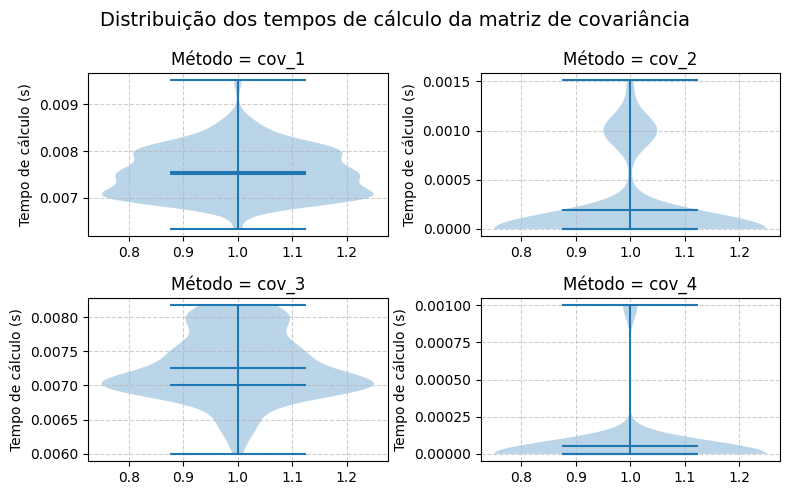

In [99]:
plot_violin_hist(times_4)

Para dados do sensor 24

In [100]:
times_24 = calc_tempos(X_24)

100%|██████████| 100/100 [00:01<00:00, 65.87it/s]

cov_1: Média = 0.007675 s | Desvio-Padrão = 0.000647 s
cov_2: Média = 0.000097 s | Desvio-Padrão = 0.000313 s
cov_3: Média = 0.007225 s | Desvio-Padrão = 0.000477 s
cov_4: Média = 0.000105 s | Desvio-Padrão = 0.000303 s


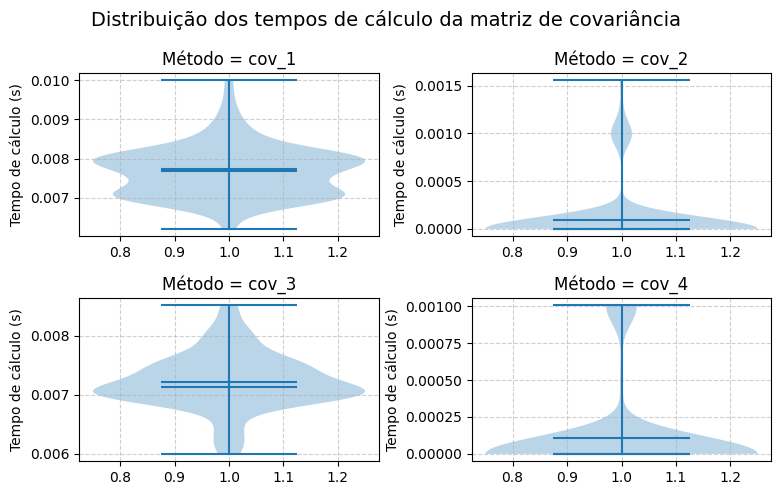

In [101]:
plot_violin_hist(times_24)

## Questão 03

Escolher o método mais rápido no Item 1 e estimar as matrizes de covariância de cada classe, avaliando suas invertibilidades comparando com a invertibilidade da matriz de covariância global através do posto e do número de condicionamento. No Matlab/Octave usar comandos rank e rcond. As matrizes em questão são invertíveis e numericamente bem-condicionadas?

In [ ]:
def analisar_e_inverter(C, nome=""):
    # Posto (Rank)
    posto = np.linalg.matrix_rank(C)
    
    # Número de Condicionamento (equivalente à análise de rcond no Matlab)
    # Valores muito altos (ex: > 1e10) indicam matriz mal condicionada
    cond_num = np.linalg.cond(C)
    
    print(f"[{nome}] Posto: {posto} | Condicionamento: {cond_num:.2e}")
    
    try:
        # Tenta inverter normalmente
        C_inv = np.linalg.inv(C)
        print(f"[{nome}] Inversão realizada com sucesso sem regularização.\n")
        return C_inv
    except np.linalg.LinAlgError:
        print(f"[{nome}] Matriz singular! Aplicando regularização...")
        # Aplica a Regularização: C_reg = C + lambda * Identidade
        lambd = 1e-6
        C_reg = C + lambd * np.eye(C.shape[0])
        C_inv = np.linalg.inv(C_reg)
        print(f"[{nome}] Inversão realizada COM regularização (lambda={lambd}).\n")
        return C_inv

Para dados do sensor 4

In [108]:
# Analisa Matriz Global
C_global = cov_4(X_4)
C_global_inv = analisar_e_inverter(C_global, "Matriz GLOBAL")

[Matriz GLOBAL] Posto: 4 | Condicionamento: 7.57e+00
[Matriz GLOBAL] Inversão realizada com sucesso sem regularização.



Para dados do sensor 24

In [109]:
# Analisa Matriz Global
C_global = cov_4(X_24)
C_global_inv = analisar_e_inverter(C_global, "Matriz GLOBAL")

[Matriz GLOBAL] Posto: 24 | Condicionamento: 2.05e+01
[Matriz GLOBAL] Inversão realizada com sucesso sem regularização.



## Questão 04

Inverter as matrizes de covariância global e de cada classe individualmente. OBS: Se houver problema de inversão destas matrizes, use alguma técnica de regularização discutidas em sala de  aula.

Para dados do sensor 24

In [110]:
# Analisa Matrizes por Classe
classes = np.unique(y_4)
for c in classes:
    X_c = X_4[y_4.ravel() == c]
    C_c = cov_2(X_c)
    C_c_inv = analisar_e_inverter(C_c, f"Matriz Classe {c}")

[Matriz Classe Move-Forward] Posto: 4 | Condicionamento: 6.43e+01
[Matriz Classe Move-Forward] Inversão realizada com sucesso sem regularização.

[Matriz Classe Sharp-Right-Turn] Posto: 4 | Condicionamento: 2.15e+02
[Matriz Classe Sharp-Right-Turn] Inversão realizada com sucesso sem regularização.

[Matriz Classe Slight-Left-Turn] Posto: 4 | Condicionamento: 1.11e+01
[Matriz Classe Slight-Left-Turn] Inversão realizada com sucesso sem regularização.

[Matriz Classe Slight-Right-Turn] Posto: 4 | Condicionamento: 2.19e+02
[Matriz Classe Slight-Right-Turn] Inversão realizada com sucesso sem regularização.



Para dados do sensor 24

In [111]:
# Analisa Matrizes por Classe
classes = np.unique(y_24)
for c in classes:
    X_c = X_24[y_24.ravel() == c]
    C_c = cov_2(X_c)
    C_c_inv = analisar_e_inverter(C_c, f"Matriz Classe {c}")

[Matriz Classe Move-Forward] Posto: 24 | Condicionamento: 5.35e+01
[Matriz Classe Move-Forward] Inversão realizada com sucesso sem regularização.

[Matriz Classe Sharp-Right-Turn] Posto: 24 | Condicionamento: 3.13e+01
[Matriz Classe Sharp-Right-Turn] Inversão realizada com sucesso sem regularização.

[Matriz Classe Slight-Left-Turn] Posto: 24 | Condicionamento: 1.73e+02
[Matriz Classe Slight-Left-Turn] Inversão realizada com sucesso sem regularização.

[Matriz Classe Slight-Right-Turn] Posto: 24 | Condicionamento: 1.96e+02
[Matriz Classe Slight-Right-Turn] Inversão realizada com sucesso sem regularização.

